<a href="https://colab.research.google.com/github/inConsciousness/Image-Captioning/blob/main/attention_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Kaggle API for dataset download
!pip install kaggle

# Install PyTorch and related libraries
!pip install torch torchvision

# Install additional libraries for visualizations and progress bars
!pip install matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
# Configure Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
files.upload()  # Upload kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srivardhanmuthyala","key":"2a12a9bdb02acf58de00584ac3a3529c"}'}

In [4]:
# Download the Flickr8k Dataset using Kaggle API
!kaggle datasets download -d adityajn105/flickr8k

# Unzip the dataset into a folder named 'flickr8k_dataset'
!unzip -o flickr8k.zip -d ./flickr8k_dataset/

Streaming output truncated to the last 5000 lines.
  inflating: ./flickr8k_dataset/Images/2844846111_8c1cbfc75d.jpg  
  inflating: ./flickr8k_dataset/Images/2844963839_ff09cdb81f.jpg  
  inflating: ./flickr8k_dataset/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: ./flickr8k_dataset/Images/2845691057_d4ab89d889.jpg  
  inflating: ./flickr8k_dataset/Images/2845845721_d0bc113ff7.jpg  
  inflating: ./flickr8k_dataset/Images/2846037553_1a1de50709.jpg  
  inflating: ./flickr8k_dataset/Images/2846785268_904c5fcf9f.jpg  
  inflating: ./flickr8k_dataset/Images/2846843520_b0e6211478.jpg  
  inflating: ./flickr8k_dataset/Images/2847514745_9a35493023.jpg  
  inflating: ./flickr8k_dataset/Images/2847615962_c330bded6e.jpg  
  inflating: ./flickr8k_dataset/Images/2847859796_4d9cb0d31f.jpg  
  inflating: ./flickr8k_dataset/Images/2848266893_9693c66275.jpg  
  inflating: ./flickr8k_dataset/Images/2848571082_26454cb981.jpg  
  inflating: ./flickr8k_dataset/Images/2848895544_6d06210e9d.jpg  
  inflating

In [5]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
import os

# Set dataset path
DATASET_PATH = "flickr8k_dataset"

# Check contents
print("Files in dataset folder:", os.listdir(DATASET_PATH))

# Check images inside the folder
image_dir = os.path.join(DATASET_PATH, "Images")
print("Sample images:", os.listdir(image_dir)[:5])

# Check captions file existence
captions_file = os.path.join(DATASET_PATH, "captions.txt")
if os.path.exists(captions_file):
    print("Captions file found.")
else:
    print("Captions file missing. Please check the dataset.")


Files in dataset folder: ['captions.txt', 'Images']
Sample images: ['2895966469_53e0b29295.jpg', '3726120436_740bda8416.jpg', '3328535573_33c3cd5b59.jpg', '222878446_32c6fc4bc9.jpg', '3562903245_85071bb5f9.jpg']
Captions file found.


In [7]:
import nltk
import string
import re
import csv

# Download NLTK resources
nltk.download('punkt_tab')

# Function to load and preprocess captions
def load_captions(file_path):
    captions_dict = {}

    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file, delimiter=',')  # Using comma as delimiter

        for row in reader:
            if len(row) < 2:
                print(f"Skipping malformed line: {row}")
                continue

            img_id = row[0].split("#")[0].strip()
            caption = row[1].strip().lower()
            caption = caption.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
            caption = re.sub(r"\s+", " ", caption).strip()  # Remove extra spaces
            tokens = nltk.word_tokenize(caption)  # Tokenize the caption

            if img_id not in captions_dict:
                captions_dict[img_id] = []

            captions_dict[img_id].append(tokens)  # Store tokenized caption

    return captions_dict

# Load and preprocess captions
captions_file = 'flickr8k_dataset/captions.txt'
captions = load_captions(captions_file)

print(f"Loaded {len(captions)} images with captions.")
print(f"Sample preprocessed caption: {captions[list(captions.keys())[0]]}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Loaded 8092 images with captions.
Sample preprocessed caption: [['caption']]


In [8]:
from collections import Counter

# Special tokens
SPECIAL_TOKENS = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]

# Function to build vocabulary from captions
def build_vocab(captions_dict, min_freq=5):
    word_counter = Counter()

    # Count frequency of each word in the captions
    for img_id, captions in captions_dict.items():
        for caption in captions:
            word_counter.update(caption)

    # Initialize vocabulary with special tokens first
    vocab = {token: idx for idx, token in enumerate(SPECIAL_TOKENS)}
    idx = len(vocab)

    # Add words to vocabulary if they meet the frequency threshold
    for word, freq in word_counter.items():
        if freq >= min_freq and word not in vocab:
            vocab[word] = idx
            idx += 1

    return vocab

# Build vocabulary
vocab = build_vocab(captions, min_freq=5)

# Ensure all special tokens are present
for token in SPECIAL_TOKENS:
    if token not in vocab:
        vocab[token] = len(vocab)

# Print vocabulary details
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample words: {list(vocab.items())[:10]}")

Vocabulary size: 2995
Sample words: [('<PAD>', 0), ('<SOS>', 1), ('<EOS>', 2), ('<UNK>', 3), ('a', 4), ('child', 5), ('in', 6), ('pink', 7), ('dress', 8), ('is', 9)]


In [9]:
# Function to encode captions into numeric sequences
def encode_captions(captions_dict, vocab):
    encoded_captions = {}
    for img_id, captions in captions_dict.items():
        encoded_captions[img_id] = []
        for caption in captions:
            encoded_caption = [vocab["<SOS>"]] + \
                              [vocab.get(word, vocab["<UNK>"]) for word in caption] + \
                              [vocab["<EOS>"]]
            encoded_captions[img_id].append(encoded_caption)
    return encoded_captions

# Encode captions using vocabulary
encoded_captions = encode_captions(captions, vocab)

# Print sample encoded caption
sample_img = list(encoded_captions.keys())[0]
print(f"Encoded captions for {sample_img}: {encoded_captions[sample_img]}")

Encoded captions for image: [[1, 3, 2]]


In [10]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Function to pad captions to a fixed length
def pad_captions(encoded_captions, pad_value=0, max_length=20):
    padded_captions = {}
    for img_id, captions in encoded_captions.items():
        padded_captions[img_id] = [
            caption + [pad_value] * (max_length - len(caption)) if len(caption) < max_length else caption[:max_length]
            for caption in captions
        ]
    return padded_captions

# Pad encoded captions
max_caption_length = 20  # Choose based on dataset analysis
padded_captions = pad_captions(encoded_captions, pad_value=vocab["<PAD>"], max_length=max_caption_length)

# Print sample padded caption
print(f"Padded captions for {sample_img}: {padded_captions[sample_img]}")


Padded captions for image: [[1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


2) Step 2 is all about Dataset Preparation and DataLoader Setup

In [11]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# ✅ Upgraded Custom Dataset for Image Captioning
class CaptionDataset(Dataset):
    def __init__(self, image_folder, captions_dict, vocab, transform=None, max_len=20):
        self.image_folder = image_folder
        self.captions_dict = captions_dict
        self.vocab = vocab
        self.transform = transform
        self.max_len = max_len

        # ✅ Filter out missing images during initialization
        self.image_ids = [img_id for img_id in captions_dict.keys() if os.path.exists(os.path.join(image_folder, img_id))]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.image_folder, img_name)

        # ✅ Handle missing or corrupt images
        try:
            with Image.open(img_path) as img:
                img.verify()  # Check if the image is valid
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, IOError):
            print(f"⚠️ Corrupt or missing image: {img_name}. Skipping.")
            return None  # Return None to handle it in collate_fn

        # ✅ Apply image transformations if available
        if self.transform:
            image = self.transform(image)

        # ✅ Ensure captions exist for the image
        if img_name not in self.captions_dict or not self.captions_dict[img_name]:
            print(f"⚠️ No captions found for image: {img_name}. Skipping.")
            return None  # Skip if no captions available

        # ✅ Select the first caption if multiple exist
        caption_list = self.captions_dict[img_name][0] if isinstance(self.captions_dict[img_name][0], list) else self.captions_dict[img_name]
        caption = " ".join(caption_list).lower().split()

        # ✅ Convert words to indices using vocabulary
        caption_idx = [self.vocab.get(word, self.vocab['<UNK>']) for word in caption]
        caption_idx = [self.vocab['<SOS>']] + caption_idx + [self.vocab['<EOS>']]

        # ✅ Pad captions to fixed length
        if len(caption_idx) < self.max_len:
            caption_idx += [self.vocab['<PAD>']] * (self.max_len - len(caption_idx))
        else:
            caption_idx = caption_idx[:self.max_len]

        return image, torch.tensor(caption_idx)

print("✅ Step 2.1: Upgraded Dataset class successfully!")

✅ Step 2.1: Upgraded Dataset class successfully!


In [12]:
# ✅ Function to remove corrupt images before dataset processing
def remove_corrupt_images(image_folder, captions_dict):
    """
    Scans the dataset folder and removes corrupt or unreadable images.
    """
    valid_captions = {}
    for img_name in list(captions_dict.keys()):
        img_path = os.path.join(image_folder, img_name)

        try:
            with Image.open(img_path) as img:
                img.verify()  # Check if the image is valid
            valid_captions[img_name] = captions_dict[img_name]
        except (FileNotFoundError, IOError):
            print(f"🗑️ Removing corrupt/missing image: {img_name}")

    return valid_captions

# ✅ Clean dataset by removing corrupt images
captions = remove_corrupt_images("flickr8k_dataset/Images/", captions)

print(f"✅ Step 2.2: Corrupt images removed. Remaining valid images: {len(captions)}")

🗑️ Removing corrupt/missing image: image
✅ Step 2.2: Corrupt images removed. Remaining valid images: 8091


In [13]:
import torchvision.transforms as transforms

# ✅ Define image preprocessing transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

print("✅ Step 2.3: Image transformations defined successfully!")


✅ Step 2.3: Image transformations defined successfully!


In [14]:
from collections import Counter

# Special tokens
SPECIAL_TOKENS = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]

# ✅ Function to build vocabulary
def build_vocab(captions_dict, min_freq=5):
    """
    Creates a vocabulary dictionary mapping words to unique indices.
    """
    word_counter = Counter()

    # Count word frequencies
    for caption_list in captions_dict.values():
        for caption in caption_list:
            words = caption if isinstance(caption, list) else caption.lower().split()
            word_counter.update(words)

    # Initialize vocabulary with special tokens
    vocab = {token: idx for idx, token in enumerate(SPECIAL_TOKENS)}
    idx = len(vocab)

    # ✅ Add words to vocabulary if they appear >= min_freq times
    for word, freq in word_counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1

    return vocab

# ✅ Build vocabulary
vocab = build_vocab(captions, min_freq=5)

# ✅ Ensure special tokens exist
for token in SPECIAL_TOKENS:
    if token not in vocab:
        vocab[token] = len(vocab)

# ✅ Print vocabulary details
print(f"✅ Vocabulary size: {len(vocab)}")
print(f"✅ Sample words: {list(vocab.items())[:10]}")
print("✅ Step 2.4: Vocabulary built successfully!")

✅ Vocabulary size: 2995
✅ Sample words: [('<PAD>', 0), ('<SOS>', 1), ('<EOS>', 2), ('<UNK>', 3), ('a', 4), ('child', 5), ('in', 6), ('pink', 7), ('dress', 8), ('is', 9)]
✅ Step 2.4: Vocabulary built successfully!


In [15]:
import torch
from torch.utils.data import DataLoader, random_split

# ✅ Paths & Parameters
image_folder = "flickr8k_dataset/Images/"  # Image folder path
batch_size = 16
val_split = 0.1  # 10% for validation
test_split = 0.1  # 10% for testing

# ✅ Initialize dataset
full_dataset = CaptionDataset(
    image_folder=image_folder,
    captions_dict=captions,  # Ensure captions are preprocessed
    vocab=vocab,  # Ensure vocabulary is initialized
    transform=image_transform  # Apply image transformations
)

# ✅ Filter out None values (i.e., missing images)
filtered_dataset = [sample for sample in full_dataset if sample is not None]

# ✅ Recalculate dataset sizes
test_size = int(test_split * len(filtered_dataset))
val_size = int(val_split * len(filtered_dataset))
train_size = len(filtered_dataset) - test_size - val_size

# ✅ Split dataset into training, validation, and test sets
train_subset, val_subset, test_subset = random_split(
    filtered_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"✅ Training Set Size: {len(train_subset)}")
print(f"✅ Validation Set Size: {len(val_subset)}")
print(f"✅ Test Set Size: {len(test_subset)}")

# ✅ Define a custom collate function to handle missing data
def custom_collate_fn(batch):
    """Filters out None samples from the batch."""
    batch = [b for b in batch if b is not None]  # Remove None entries
    return torch.utils.data.dataloader.default_collate(batch)

# ✅ Ensure batch size is the same across all DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)

# ✅ Print dataset sizes for confirmation
print(f"✅ Training DataLoader: {len(train_loader)} batches")
print(f"✅ Validation DataLoader: {len(val_loader)} batches")
print(f"✅ Test DataLoader: {len(test_loader)} batches")
print("\n✅ Step 2.5: Dataset successfully split and verified!")

✅ Training Set Size: 6473
✅ Validation Set Size: 809
✅ Test Set Size: 809
✅ Training DataLoader: 405 batches
✅ Validation DataLoader: 51 batches
✅ Test DataLoader: 51 batches

✅ Step 2.5: Dataset successfully split and verified!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🔍 Running Exploratory Data Analysis (EDA)...


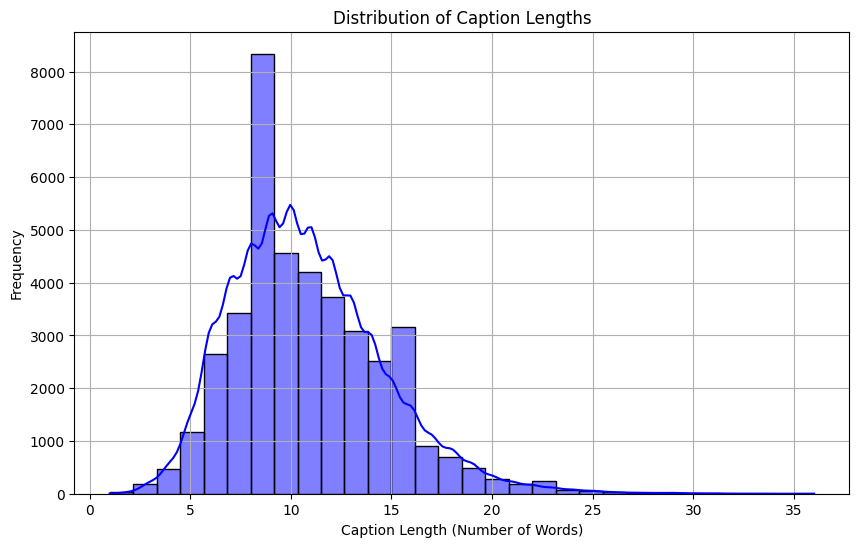

✅ Caption Length Distribution Visualized!


<ipython-input-16-c0917b84e16b>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


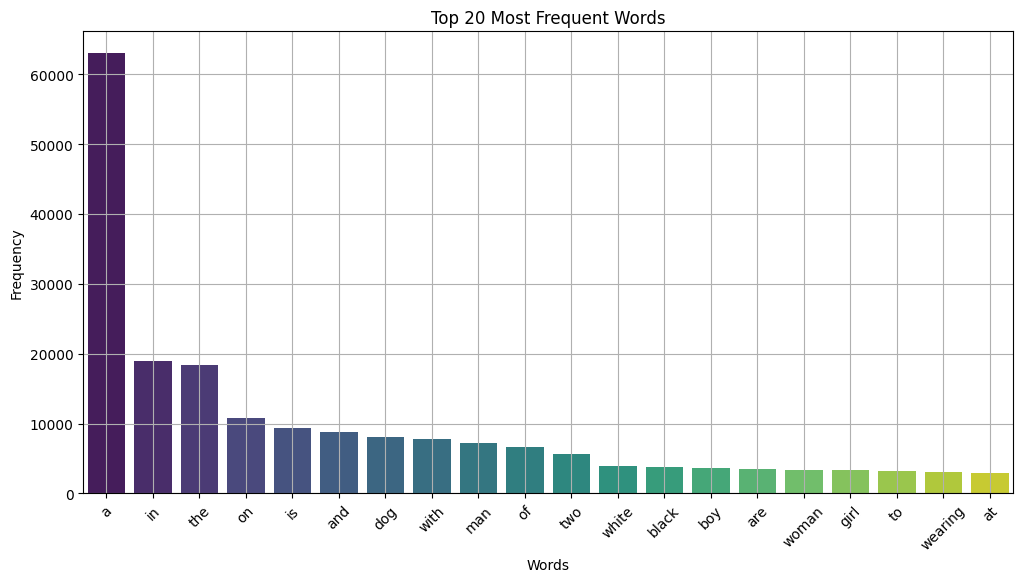

✅ Most Frequent Words Visualized!

✅ Step 2.6: Exploratory Data Analysis (EDA) Completed Successfully!


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# 1️⃣ Function to Plot Caption Length Distribution
def plot_caption_lengths(captions_dict):
    """
    Plots the distribution of caption lengths.
    """
    caption_lengths = [len(caption) for caption_list in captions_dict.values() for caption in caption_list]

    plt.figure(figsize=(10, 6))
    sns.histplot(caption_lengths, kde=True, bins=30, color='blue')
    plt.title("Distribution of Caption Lengths")
    plt.xlabel("Caption Length (Number of Words)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()
    print("✅ Caption Length Distribution Visualized!")

# 2️⃣ Function to Plot Most Frequent Words
def plot_most_frequent_words(captions_dict, top_n=20):
    """
    Plots the most frequent words in the dataset captions.
    """
    word_counts = Counter()
    for caption_list in captions_dict.values():
        for caption in caption_list:
            word_counts.update(caption)

    words, counts = zip(*word_counts.most_common(top_n))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(words), y=list(counts), palette="viridis")
    plt.title(f"Top {top_n} Most Frequent Words")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
    print("✅ Most Frequent Words Visualized!")

# 📌 Run EDA functions
print("\n🔍 Running Exploratory Data Analysis (EDA)...")
plot_caption_lengths(captions)
plot_most_frequent_words(captions, top_n=20)

print("\n✅ Step 2.6: Exploratory Data Analysis (EDA) Completed Successfully!")

In [17]:
import torch
import string
import re
import nltk

# ✅ Download NLTK tokenizer
nltk.download('punkt')

# ✅ Function to preprocess captions
def preprocess_captions(captions_dict):
    """
    Cleans, tokenizes, and encodes captions for training.
    """
    processed_captions = {}
    for img_id, caption_list in captions_dict.items():
        processed_captions[img_id] = []
        for caption in caption_list:
            if isinstance(caption, list):  # Ensure caption is a string
                caption = " ".join(caption)  # Convert list to string

            caption = caption.lower().translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
            caption = re.sub(r"\s+", " ", caption).strip()  # Remove extra spaces
            tokens = nltk.word_tokenize(caption)  # Tokenize

            processed_captions[img_id].append(tokens)  # Store tokenized caption

    return processed_captions

# ✅ Apply preprocessing to captions
captions = preprocess_captions(captions)

print(f"✅ Step 2.7: Captions preprocessed successfully!")
print(f"Sample preprocessed caption: {captions[list(captions.keys())[0]]}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Step 2.7: Captions preprocessed successfully!
Sample preprocessed caption: [['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way'], ['a', 'girl', 'going', 'into', 'a', 'wooden', 'building'], ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse'], ['a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse'], ['a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin']]


In [18]:
# ✅ Function to encode captions into numeric sequences
def encode_captions(captions_dict, vocab):
    encoded_captions = {}
    for img_id, captions in captions_dict.items():
        encoded_captions[img_id] = []
        for caption in captions:
            encoded_caption = [vocab["<SOS>"]] + \
                              [vocab.get(word, vocab["<UNK>"]) for word in caption] + \
                              [vocab["<EOS>"]]
            encoded_captions[img_id].append(encoded_caption)
    return encoded_captions

# ✅ Encode captions
encoded_captions = encode_captions(captions, vocab)

# ✅ Print sample encoded caption
sample_img = list(encoded_captions.keys())[0]
print(f"✅ Encoded captions for {sample_img}: {encoded_captions[sample_img]}")

✅ Encoded captions for 1000268201_693b08cb0e.jpg: [[1, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 3, 16, 2], [1, 4, 17, 18, 19, 4, 20, 21, 2], [1, 4, 22, 17, 10, 19, 4, 20, 23, 2], [1, 4, 22, 17, 10, 24, 14, 25, 26, 23, 2], [1, 4, 22, 17, 6, 4, 7, 8, 18, 19, 4, 20, 3, 2]]


In [19]:
import torch

# ✅ Function to pad captions to a fixed length
def pad_captions(encoded_captions, pad_value=0, max_length=20):
    padded_captions = {}
    for img_id, captions in encoded_captions.items():
        padded_captions[img_id] = [
            caption + [pad_value] * (max_length - len(caption)) if len(caption) < max_length else caption[:max_length]
            for caption in captions
        ]
    return padded_captions

# ✅ Pad encoded captions
max_caption_length = 20
padded_captions = pad_captions(encoded_captions, pad_value=vocab["<PAD>"], max_length=max_caption_length)

# ✅ Print sample padded caption
print(f"✅ Padded captions for {sample_img}: {padded_captions[sample_img]}")

✅ Padded captions for 1000268201_693b08cb0e.jpg: [[1, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 3, 16, 2, 0], [1, 4, 17, 18, 19, 4, 20, 21, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 4, 22, 17, 10, 19, 4, 20, 23, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 4, 22, 17, 10, 24, 14, 25, 26, 23, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 4, 22, 17, 6, 4, 7, 8, 18, 19, 4, 20, 3, 2, 0, 0, 0, 0, 0, 0]]


In [20]:
from torch.utils.data import DataLoader, random_split

# ✅ Custom collate function to handle variable-length sequences
def collate_fn(batch):
    """
    Custom function to filter out None samples and ensure batch consistency.
    """
    batch = [b for b in batch if b is not None]  # ✅ Remove None values

    if len(batch) == 0:
        return None  # ✅ Skip empty batches

    # ✅ Extract only (images, captions)
    images, captions = zip(*batch)

    return torch.stack(images, dim=0), torch.stack(captions, dim=0)  # ✅ Return exactly two values
# ✅ Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

# ✅ Print DataLoader sizes for verification
print(f"✅ Training DataLoader: {len(train_loader)} batches")
print(f"✅ Validation DataLoader: {len(val_loader)} batches")
print(f"✅ Test DataLoader: {len(test_loader)} batches")
print("\n✅ Step 2.10: DataLoader setup completed successfully!")

✅ Training DataLoader: 405 batches
✅ Validation DataLoader: 51 batches
✅ Test DataLoader: 51 batches

✅ Step 2.10: DataLoader setup completed successfully!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


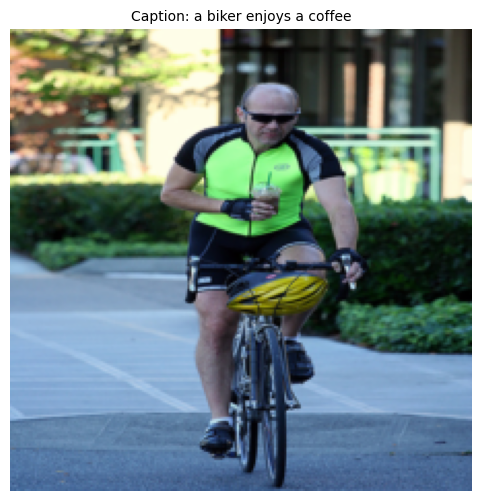


✅ Visualized sample image with caption: a biker enjoys a coffee

✅ Step 2.11: Dataset visualization completed successfully!


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import random

# ✅ Function to visualize a single random image with its caption
def visualize_sample(dataset, vocab):
    idx = random.randint(0, len(dataset) - 1)
    image, caption_idx = dataset[idx]

    # Convert tensor image to numpy format
    img = image.permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)  # Clip values to valid range

    # Convert caption indices back to words
    caption_text = [word for idx in caption_idx.tolist() if idx in vocab.values()
                    for word, word_idx in vocab.items() if word_idx == idx]

    # Remove special tokens
    filtered_caption = [word for word in caption_text if word not in ["<SOS>", "<EOS>", "<PAD>"]]
    caption_str = ' '.join(filtered_caption)

    # Display image with caption
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Caption: {caption_str}", fontsize=10)
    plt.show()

    print(f"\n✅ Visualized sample image with caption: {caption_str}")

# ✅ Run visualization for training dataset
visualize_sample(train_subset, vocab)

print("\n✅ Step 2.11: Dataset visualization completed successfully!")

In [22]:
# 🔍 Verify dataset properties
print(f"✅ Total images in dataset: {len(padded_captions)}")

# ✅ Check a few samples
for img_name, caption_list in list(padded_captions.items())[:3]:
    print(f"\nImage: {img_name}")
    for caption in caption_list:
        caption_text = [word for idx in caption for word, word_idx in vocab.items() if word_idx == idx]
        print(f"Caption: {' '.join(caption_text)}")

print("\n✅ Step 2.12: Final dataset verification completed successfully!")

✅ Total images in dataset: 8091

Image: 1000268201_693b08cb0e.jpg
Caption: <SOS> a child in a pink dress is climbing up a set of stairs in an <UNK> way <EOS> <PAD>
Caption: <SOS> a girl going into a wooden building <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Caption: <SOS> a little girl climbing into a wooden playhouse <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Caption: <SOS> a little girl climbing the stairs to her playhouse <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Caption: <SOS> a little girl in a pink dress going into a wooden <UNK> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Image: 1001773457_577c3a7d70.jpg
Caption: <SOS> a black dog and a spotted dog are fighting <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Caption: <SOS> a black dog and a tricolored dog playing with each other on the road <EOS> <PAD> <PAD> <PAD> <PAD>
Caption: <SOS> a black dog and a white dog with brown spots are staring at each 

3) Step 3: Model Architecture Setup

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad = False  # Freeze ResNet layers

        modules = list(resnet.children())[:-2]  # Retain spatial dimensions
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # Ensure 7x7 spatial output
        self.fc = nn.Linear(2048, embed_size)  # Transform ResNet output to embed_size
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)  # (batch_size, 2048, 7, 7)
        features = self.adaptive_pool(features).view(features.size(0), 49, -1)  # (batch_size, 49, 2048)
        features = self.fc(features)  # (batch_size, 49, embed_size)

        # ✅ Apply BatchNorm
        batch_size, num_pixels, embed_size = features.shape
        features = features.view(batch_size * num_pixels, embed_size)
        features = self.bn(features)
        features = features.view(batch_size, num_pixels, embed_size)

        return features  # (batch_size, 49, embed_size)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # Transform encoder output
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # Transform decoder hidden state
        self.full_att = nn.Linear(attention_dim, 1)  # Compute attention scores
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Normalize attention weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Args:
            encoder_out (tensor): Encoder feature maps (batch_size, num_pixels, encoder_dim)
            decoder_hidden (tensor): Decoder hidden state (batch_size, decoder_dim)
        Returns:
            context (tensor): Attention-weighted encoding (batch_size, encoder_dim)
            alpha (tensor): Attention weights (batch_size, num_pixels)
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # (batch_size, 1, attention_dim)

        # ✅ Additive Attention Calculation (Bahdanau)
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)

        # ✅ Compute weighted sum of encoder outputs
        context = torch.sum(encoder_out * alpha.unsqueeze(2), dim=1)  # (batch_size, encoder_dim)

        return context, alpha

In [25]:
import torch
import torch.nn as nn

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, attention_dim, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)  # Word embedding layer
        self.attention = BahdanauAttention(embed_size, hidden_size, attention_dim)  # Bahdanau Attention
        self.context_transform = nn.Linear(embed_size, hidden_size)  # ✅ Fix: Transform context to match hidden_size
        self.lstm = nn.LSTM(embed_size + hidden_size, hidden_size, num_layers, batch_first=True)  # LSTM
        self.fc = nn.Linear(hidden_size, vocab_size)  # Fully connected layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.shape[0]  # Get batch size
        embeddings = self.embed(captions)  # (batch_size, max_seq_length, embed_size)

        # Initialize hidden & cell states
        h, c = torch.zeros(1, batch_size, hidden_size).to(encoder_out.device), \
               torch.zeros(1, batch_size, hidden_size).to(encoder_out.device)

        outputs = []
        for t in range(embeddings.shape[1]):  # Loop through caption words
            word_embedding = embeddings[:, t, :].unsqueeze(1)  # (batch_size, 1, embed_size)

            # Compute Attention
            context, _ = self.attention(encoder_out, h[-1])  # (batch_size, embed_size)

            # ✅ Fix: Transform `context` to match `hidden_size`
            context = self.context_transform(context)  # (batch_size, hidden_size)

            # ✅ Expand across sequence dimension to match captions
            context = context.unsqueeze(1).expand(-1, word_embedding.shape[1], -1)  # (batch_size, 1, hidden_size)

            # ✅ Concatenate context + embeddings correctly
            lstm_input = torch.cat((context, word_embedding), dim=2)  # (batch_size, 1, embed_size + hidden_size)

            # Pass through LSTM
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))  # (batch_size, 1, hidden_size)

            # Generate word predictions
            output = self.fc(lstm_out.squeeze(1))  # (batch_size, vocab_size)
            outputs.append(output)

        outputs = torch.stack(outputs, dim=1)  # (batch_size, max_seq_length, vocab_size)

        return outputs


In [26]:
import torch

# ✅ Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define Model Hyperparameters
batch_size = 4
image_size = (3, 224, 224)  # Standard ImageNet size
embed_size = 256  # Feature embedding size
hidden_size = 512  # LSTM hidden size
attention_dim = 256  # Attention layer size
vocab_size = 10000  # Example vocabulary size
max_seq_length = 10  # Caption max length

# ✅ Initialize Models & Move to Device
encoder = EncoderCNN(embed_size).to(device)
attention = BahdanauAttention(encoder_dim=embed_size, decoder_dim=hidden_size, attention_dim=attention_dim).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, attention_dim, num_layers=1).to(device)

# ✅ Generate Dummy Inputs & Move to Device
dummy_images = torch.randn(batch_size, *image_size).to(device)  # Fake batch of images
dummy_captions = torch.randint(0, vocab_size, (batch_size, max_seq_length)).to(device)  # Fake captions (word indices)

# ✅ Pass through Encoder
encoder.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient calculations
    features = encoder(dummy_images)

print(f"✅ Encoder Output Shape: {features.shape}")  # Expected: (batch_size, num_pixels, 256)

# ✅ Compute `num_pixels` dynamically
num_pixels = features.shape[1]  # Should be 49 (7x7 grid from ResNet)

# ✅ Pass through Decoder
decoder.eval()
with torch.no_grad():
    decoder_output = decoder(features, dummy_captions)

print(f"✅ Decoder Output Shape: {decoder_output.shape}")  # Expected: (batch_size, max_seq_length, vocab_size)

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


✅ Encoder Output Shape: torch.Size([4, 49, 256])
✅ Decoder Output Shape: torch.Size([4, 10, 10000])


In [27]:


# ✅ Full Captioning Model (Combining Encoder, Attention, and Decoder)
class CaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Full Image Captioning Model.
        Args:
            encoder (EncoderCNN): The CNN-based image feature extractor.
            decoder (DecoderRNN): The RNN-based caption decoder with attention.
        """
        super(CaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        """
        Forward pass of the full model.
        Args:
            images (tensor): Input image tensor (batch_size, 3, 224, 224).
            captions (tensor): Ground-truth captions (batch_size, max_length).
        Returns:
            Generated captions (batch_size, max_length, vocab_size).
        """
        features = self.encoder(images)  # Extract image features from Encoder
        outputs = self.decoder(features, captions)  # Generate captions from Decoder
        return outputs


# ✅ Instantiate Encoder and Decoder
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)  # Vocabulary size
attention_dim = 256

encoder = EncoderCNN(embed_size)  # Initialize Encoder
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, attention_dim)  # Initialize Decoder

# ✅ Full Captioning Model
captioning_model = CaptioningModel(encoder, decoder)

print("✅ Step 3.4: Full Captioning Model (Encoder + Attention + Decoder) Defined!")

✅ Step 3.4: Full Captioning Model (Encoder + Attention + Decoder) Defined!


 **Step 5: Train the Model**

In [28]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.7/648.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.9 MB/s eta 0:00:00


**🛠 Step 5: Train the Model **
**📌 Step 5.1: Define Loss Function & Optimizer**
Choose CrossEntropyLoss for caption generation.
Set ignore_index to avoid computing loss for padding tokens.
Use Adam or AdamW optimizer for better performance.
Set an appropriate learning rate.
**📌 Step 5.2: Implement Training Loop**
Loop through epochs (e.g., 10-20 epochs based on model performance).
Set model to train mode before starting each epoch.
Iterate over DataLoader batches:
Move images and captions to GPU (if available).
Pass images through Encoder to get feature maps.
Pass feature maps and captions through Decoder.
Compute loss between predicted captions and ground truth.
Perform backpropagation and update model weights.
**📌 Step 5.3: Implement Gradient Clipping (Prevent Exploding Gradients)**
Apply clip_grad_norm_ to restrict the gradient magnitude.
Helps stabilize training, especially for RNN-based models.
📌 Step 5.4: Save Model Checkpoints
Save model weights at regular intervals.
Use naming convention like model_epoch_{epoch}.pth.
Ensure the best-performing model is saved.
📌 Step 5.5: Implement Logging & Monitoring
Track training loss over epochs.
Log key metrics using MLflow or TensorBoard.
Print batch-wise loss for debugging.
Save loss plots for performance visualization.
📌 Step 5.6: Validate Model Performance
After each epoch, switch model to eval mode.
Run inference on validation set.
Compute validation loss and monitor over epochs.
If validation loss stops decreasing, consider early stopping.


In [29]:
import torch.nn as nn
import torch.optim as optim

# Define CrossEntropyLoss with ignore_index for PAD token
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])

# Use Adam optimizer with a learning rate
learning_rate = 0.001
optimizer = optim.Adam(captioning_model.parameters(), lr=learning_rate)

print("✅ Loss function and optimizer initialized!")

✅ Loss function and optimizer initialized!


**Step 5.2: Implement Training Loop (Batch-wise Processing)**

In [30]:
!pip install mlflow


In [31]:
!pip install nltk sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00


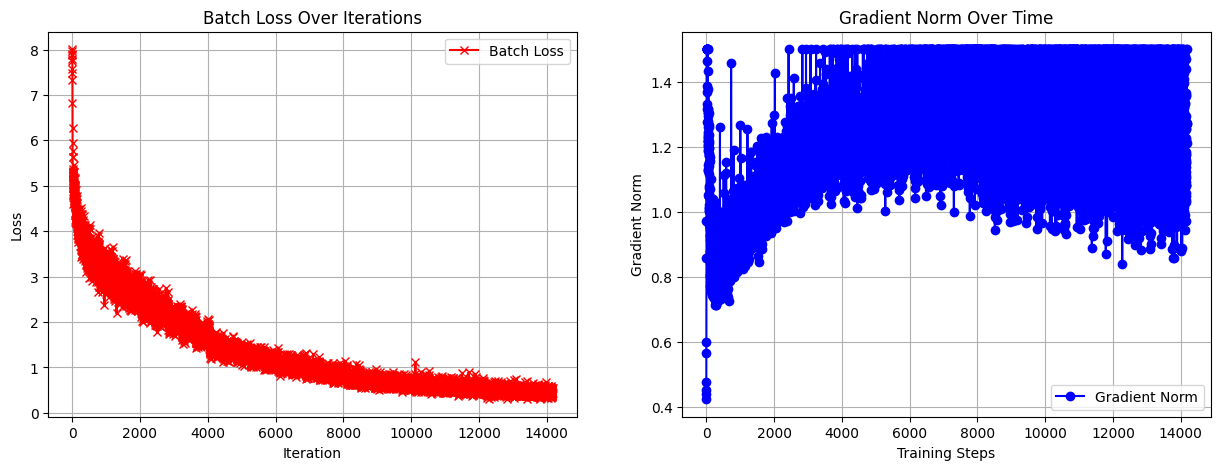

🔹 Epoch 35/35 - Avg Loss: 0.4510
✅ Model checkpoint saved: model_checkpoints/captioning_model_epoch_35.pth


2025/03/06 14:03:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/06 14:03:55 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/06 14:03:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Training loop completed with history tracking!


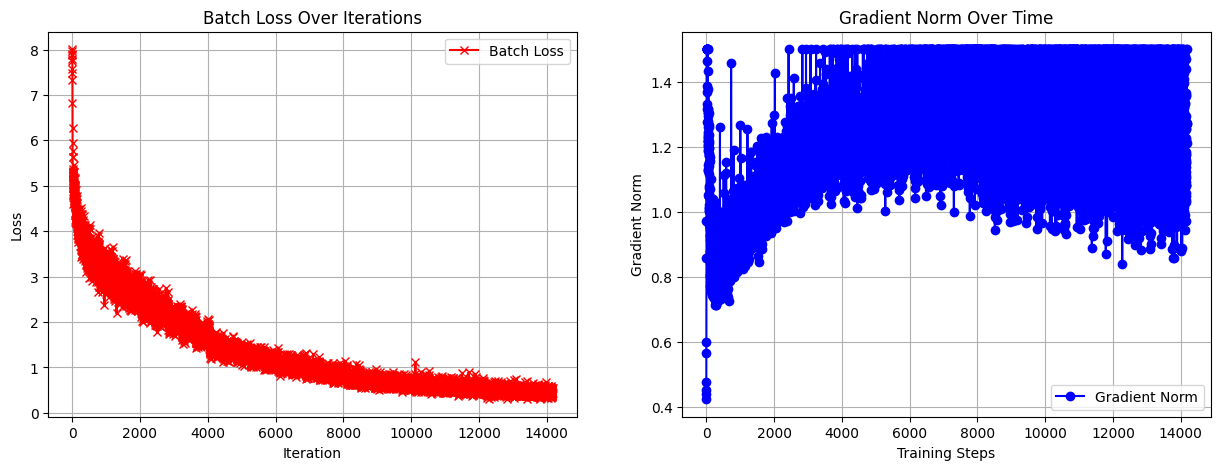

In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display, clear_output

# ✅ Define optimized hyperparameters
training_config = {
    "num_epochs": 35,         # Reduced epochs to prevent overfitting
    "learning_rate": 5e-4,    # Lowered initial learning rate
    "batch_size": 64,         # Increased batch size for stability
    "clip_grad_norm": 1.5,    # Reduced gradient clipping
    "log_interval": 50,       # Log every N batches
    "checkpoint_dir": "model_checkpoints"  # Directory to save checkpoints
}

# ✅ Ensure checkpoint directory exists
os.makedirs(training_config["checkpoint_dir"], exist_ok=True)

# ✅ Move model to correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
captioning_model.to(device)

# ✅ Define loss function & optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])
optimizer = optim.AdamW(captioning_model.parameters(), lr=training_config["learning_rate"], weight_decay=1e-4)

# ✅ Learning Rate Scheduler (Step Decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ✅ Early Stopping (Reduce LR on Plateau)
early_stopping = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True)

# ✅ Check if previous checkpoints exist
latest_checkpoint = None
start_epoch = 0  # Default to start from epoch 0

if os.path.exists(training_config["checkpoint_dir"]) and len(os.listdir(training_config["checkpoint_dir"])) > 0:
    latest_checkpoint = sorted(os.listdir(training_config["checkpoint_dir"]))[-1]  # Get latest checkpoint file
    latest_checkpoint_path = os.path.join(training_config["checkpoint_dir"], latest_checkpoint)

    # ✅ Prompt the user: Resume or Start Fresh?
    print(f"🔄 Found existing checkpoint: {latest_checkpoint}")
    choice = input("Do you want to resume from last checkpoint? (yes/no): ").strip().lower()

    if choice == "yes":
        print(f"🔄 Resuming from checkpoint: {latest_checkpoint}")

        # ✅ Load model, optimizer, and last saved epoch
        checkpoint = torch.load(latest_checkpoint_path, map_location=device)
        captioning_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']  # Resume from last saved epoch

        print(f"✅ Resumed training from epoch {start_epoch}")

    else:
        print("🛑 Starting training from scratch! Clearing old checkpoints...")

        # ✅ Remove all existing checkpoints
        for file in os.listdir(training_config["checkpoint_dir"]):
            os.remove(os.path.join(training_config["checkpoint_dir"], file))

        start_epoch = 0  # Reset epoch

# ✅ Function to apply adaptive gradient clipping
def apply_gradient_clipping(model, clip_norm):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)

# ✅ Initialize `history` dictionary for tracking metrics
history = defaultdict(list)

# ✅ Training loop with real-time logging & history tracking
with mlflow.start_run():
    mlflow.log_params(training_config)  # ✅ Log hyperparameters

    plt.figure(figsize=(15, 5))  # Create figure for real-time plots

    for epoch in range(start_epoch, training_config["num_epochs"]):  # ✅ Resume or start from 0
        captioning_model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            if batch is None:
                continue

            images, captions = batch
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()

            outputs = captioning_model(images, captions[:, :-1])  # Teacher forcing
            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))

            loss.backward()
            apply_gradient_clipping(captioning_model, clip_norm=training_config["clip_grad_norm"])

            # ✅ Compute and store gradient norm
            grad_norm = torch.nn.utils.clip_grad_norm_(captioning_model.parameters(), max_norm=training_config["clip_grad_norm"])

            optimizer.step()
            total_loss += loss.item()

            # ✅ Store batch-wise metrics in `history`
            step_num = batch_idx + epoch * len(train_loader)
            history["batch_loss"].append(loss.item())
            history["gradient_norm"].append(grad_norm.item())
            history["learning_rate"].append(optimizer.param_groups[0]["lr"])
            history["batch_step"].append(step_num)  # Track iterations

            if batch_idx % training_config["log_interval"] == 0:
                print(f"Epoch [{epoch+1}/{training_config['num_epochs']}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
                mlflow.log_metric("batch_loss", loss.item(), step=step_num)

                # ✅ Live update of training graphs
                clear_output(wait=True)
                plt.clf()

                # ✅ Plot Batch Loss Over Iterations
                plt.subplot(1, 2, 1)
                plt.plot(history["batch_step"], history["batch_loss"], marker='x', linestyle='-', color='r', label="Batch Loss")
                plt.xlabel("Iteration")
                plt.ylabel("Loss")
                plt.title("Batch Loss Over Iterations")
                plt.legend()
                plt.grid()

                # ✅ Plot Gradient Norm Over Iterations
                plt.subplot(1, 2, 2)
                plt.plot(history["batch_step"], history["gradient_norm"], marker='o', linestyle='-', color='b', label="Gradient Norm")
                plt.xlabel("Training Steps")
                plt.ylabel("Gradient Norm")
                plt.title("Gradient Norm Over Time")
                plt.legend()
                plt.grid()

                display(plt.gcf())  # Show updated plots

        avg_loss = total_loss / len(train_loader)
        history["epoch_loss"].append(avg_loss)
        history["epoch"].append(epoch + 1)  # Store epoch number

        print(f"🔹 Epoch {epoch+1}/{training_config['num_epochs']} - Avg Loss: {avg_loss:.4f}")
        mlflow.log_metric("epoch_loss", avg_loss, step=epoch)

        # ✅ Adjust learning rate based on validation loss
        lr_scheduler.step()  # Reduce learning rate after fixed step size
        early_stopping.step(avg_loss)  # Reduce learning rate if no improvement

        # ✅ Save model checkpoint
        checkpoint_path = os.path.join(training_config["checkpoint_dir"], f"captioning_model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,  # Save next epoch to start from
            'model_state_dict': captioning_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, checkpoint_path)

        print(f"✅ Model checkpoint saved: {checkpoint_path}")

    mlflow.pytorch.log_model(captioning_model, "model")

print("✅ Training loop completed with history tracking!")

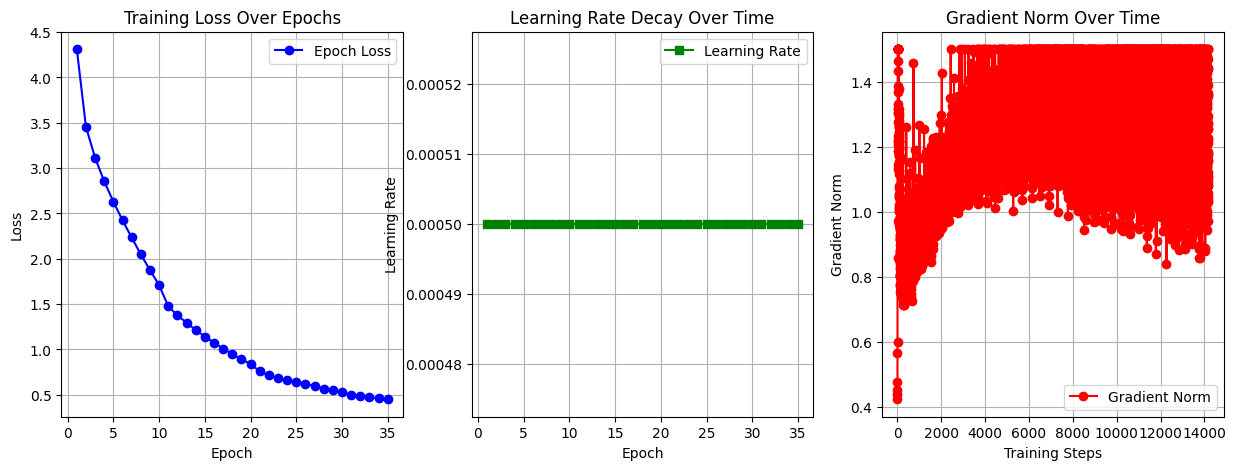

✅ Final training graphs plotted successfully!


In [33]:
# ✅ Final Training Loss, Learning Rate & Gradient Norm Graphs
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# ✅ Plot Training Loss Over Epochs
plt.subplot(1, 3, 1)
plt.plot(history["epoch"], history["epoch_loss"], marker='o', linestyle='-', color='b', label="Epoch Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()

# ✅ Plot Learning Rate Decay Over Epochs
plt.subplot(1, 3, 2)
plt.plot(history["epoch"], history["learning_rate"][:len(history["epoch"])], marker='s', linestyle='-', color='g', label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Decay Over Time")
plt.legend()
plt.grid()

# ✅ Plot Gradient Norm Over Epochs
plt.subplot(1, 3, 3)
plt.plot(history["batch_step"], history["gradient_norm"], marker='o', linestyle='-', color='r', label="Gradient Norm")
plt.xlabel("Training Steps")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Over Time")
plt.legend()
plt.grid()

plt.show()
print("✅ Final training graphs plotted successfully!")

In [34]:
import torch
import os

# ✅ Get the latest/best model checkpoint
checkpoint_dir = training_config["checkpoint_dir"]
latest_checkpoint = sorted(os.listdir(checkpoint_dir))[-1]  # Assuming last saved is best
latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

# ✅ Function to load the checkpoint
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Loads the model checkpoint.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

# ✅ Load the model
last_epoch, last_loss = load_checkpoint(captioning_model, optimizer, latest_checkpoint_path)

print(f"✅ Loaded model from {latest_checkpoint} (Epoch {last_epoch}, Loss {last_loss:.4f})")

<ipython-input-34-c9ca3315c7c9>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


✅ Loaded model from captioning_model_epoch_9.pth (Epoch 9, Loss 1.8764)


In [35]:
import torch
import random

# ✅ Function to generate captions
def generate_caption(image_tensor, model, vocab, max_length=20):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
        features = model.encoder(image_tensor)
        generated_caption = [vocab["<SOS>"]]

        for _ in range(max_length):
            caption_tensor = torch.tensor(generated_caption).unsqueeze(0).to(device)
            output = model.decoder(features, caption_tensor)
            predicted_id = output.argmax(2)[:, -1].item()

            if predicted_id == vocab["<EOS>"]:
                break
            generated_caption.append(predicted_id)

    # Convert indices to words
    rev_vocab = {idx: word for word, idx in vocab.items()}
    caption_words = [rev_vocab[idx] for idx in generated_caption if idx in rev_vocab]
    return " ".join(caption_words[1:])  # Remove <SOS> token

# ✅ Select a few random validation images
num_samples = 5
random_indices = random.sample(range(len(val_loader)), num_samples)

# ✅ Generate captions for selected images
generated_captions = []
true_captions = []
sample_images = []

for idx in random_indices:
    img_tensor, true_caption = val_subset[idx]  # Fetch a single image and its true caption

    generated_caption = generate_caption(img_tensor, captioning_model, vocab)
    true_caption_text = " ".join([word for idx in true_caption.tolist() for word, word_idx in vocab.items() if word_idx == idx and word not in ["<SOS>", "<EOS>", "<PAD>"]])

    generated_captions.append(generated_caption)
    true_captions.append(true_caption_text)
    sample_images.append(img_tensor)

# ✅ Print results
for i in range(num_samples):
    print(f"🔹 Sample {i+1}")
    print(f"🖼️ Actual Caption: {true_captions[i]}")
    print(f"🤖 Generated Caption: {generated_captions[i]}")
    print("-" * 50)

🔹 Sample 1
🖼️ Actual Caption: a black dog carries a tree branch through the woods
🤖 Generated Caption: a black and brown dog is running through the grass
--------------------------------------------------
🔹 Sample 2
🖼️ Actual Caption: a boy plays in the ocean with a boogie board
🤖 Generated Caption: a boy in a pool with a blue swimsuit in the water
--------------------------------------------------
🔹 Sample 3
🖼️ Actual Caption: two girls in karate uniforms struggle in a <UNK>
🤖 Generated Caption: a man in a black shirt is standing in a crowd of people
--------------------------------------------------
🔹 Sample 4
🖼️ Actual Caption: a little boy chases chickens
🤖 Generated Caption: a girl in a pink shirt and black pants and a black dog are playing in the grass
--------------------------------------------------
🔹 Sample 5
🖼️ Actual Caption: a group of people in protective gear
🤖 Generated Caption: a man in a black and white shirt is riding a bicycle on a bicycle with his bike and a
------

In [36]:
sample_image_tensor, _ = next(iter(val_loader))  # Get a sample image
generated_caption = generate_caption(sample_image_tensor[0], captioning_model, vocab)
print(f"📝 Generated Caption: {generated_caption}")

📝 Generated Caption: a man is surfing a wave on a surfboard


In [37]:
# ✅ Install missing libraries if needed
!pip install sacrebleu nltk


In [38]:

# ✅ Import required libraries
import torch
import os
import nltk
import sacrebleu
from nltk.translate.meteor_score import meteor_score

# ✅ Download necessary NLTK resources
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [39]:
# ✅ Evaluate on validation set
bleu_scores = []
meteor_scores = []

for batch in val_loader:
    if batch is None or len(batch) != 2:  # ✅ Ensure batch has exactly 2 elements
        continue

    images, captions = batch  # ✅ Correct unpacking

    for i in range(len(images)):  # ✅ Process images one by one
        img_tensor = images[i]
        true_caption = captions[i]

        # ✅ Convert true caption (indices → words)
        true_caption_text = " ".join(
            [word for idx in true_caption.tolist() for word, word_idx in vocab.items()
             if word_idx == idx and word not in ["<SOS>", "<EOS>", "<PAD>"]]
        )
        generated_caption = generate_caption(img_tensor, captioning_model, vocab)

        # ✅ Compute BLEU and METEOR scores
        bleu = sacrebleu.sentence_bleu(generated_caption, [true_caption_text]).score
        meteor = meteor_score([true_caption_text.split()], generated_caption.split())

        bleu_scores.append(bleu)
        meteor_scores.append(meteor)

# ✅ Compute final evaluation scores
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_meteor = sum(meteor_scores) / len(meteor_scores)

print(f"🔹 Evaluation Completed! BLEU Score: {avg_bleu:.2f}, METEOR Score: {avg_meteor:.2f}")

🔹 Evaluation Completed! BLEU Score: 8.13, METEOR Score: 0.23


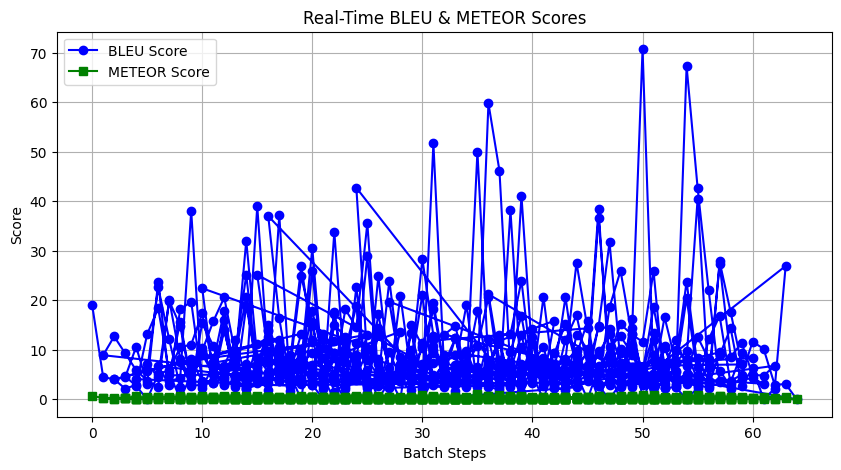


📊 **Evaluation Completed!**
✅ **Final BLEU Score:** 8.13
✅ **Final METEOR Score:** 0.23


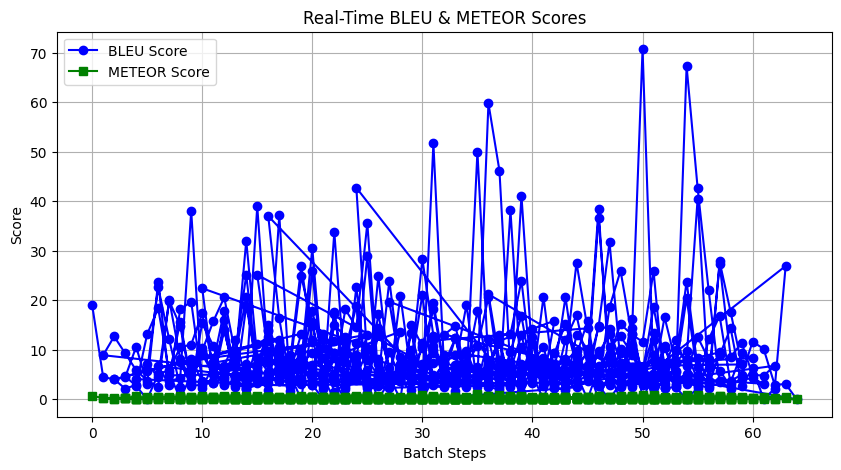

In [40]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# ✅ Initialize lists for scores & plotting
bleu_scores = []
meteor_scores = []
batch_steps = []

# ✅ Initialize real-time plotting
plt.figure(figsize=(10, 5))

# ✅ Evaluate on validation set
for batch_idx, batch in enumerate(val_loader):
    if batch is None or len(batch) != 2:  # ✅ Ensure batch has exactly 2 elements
        continue

    images, captions = batch  # ✅ Correct unpacking

    for i in range(len(images)):  # ✅ Process images one by one
        img_tensor = images[i]
        true_caption = captions[i]

        # ✅ Convert true caption (indices → words)
        true_caption_text = " ".join(
            [word for idx in true_caption.tolist() for word, word_idx in vocab.items()
             if word_idx == idx and word not in ["<SOS>", "<EOS>", "<PAD>"]]
        )
        generated_caption = generate_caption(img_tensor, captioning_model, vocab)

        # ✅ Compute BLEU and METEOR scores
        bleu = sacrebleu.sentence_bleu(generated_caption, [true_caption_text]).score
        meteor = meteor_score([true_caption_text.split()], generated_caption.split())

        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        batch_steps.append(batch_idx + i)  # ✅ Track progress

        # ✅ Real-Time Plot Update
        clear_output(wait=True)
        plt.clf()
        plt.plot(batch_steps, bleu_scores, marker='o', linestyle='-', color='b', label="BLEU Score")
        plt.plot(batch_steps, meteor_scores, marker='s', linestyle='-', color='g', label="METEOR Score")
        plt.xlabel("Batch Steps")
        plt.ylabel("Score")
        plt.title("Real-Time BLEU & METEOR Scores")
        plt.legend()
        plt.grid()
        display(plt.gcf())

# ✅ Compute final evaluation scores
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_meteor = sum(meteor_scores) / len(meteor_scores)

print(f"\n📊 **Evaluation Completed!**")
print(f"✅ **Final BLEU Score:** {avg_bleu:.2f}")
print(f"✅ **Final METEOR Score:** {avg_meteor:.2f}")

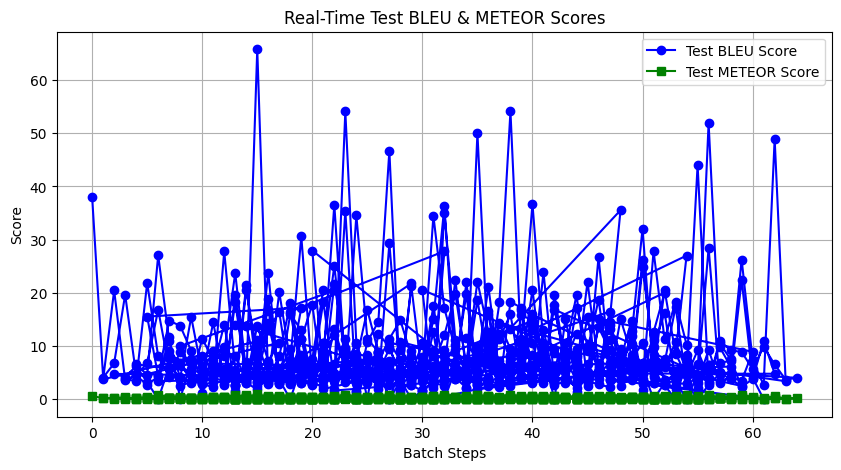


📊 **Test Evaluation Completed!**
✅ **Final Test BLEU Score:** 8.07
✅ **Final Test METEOR Score:** 0.22


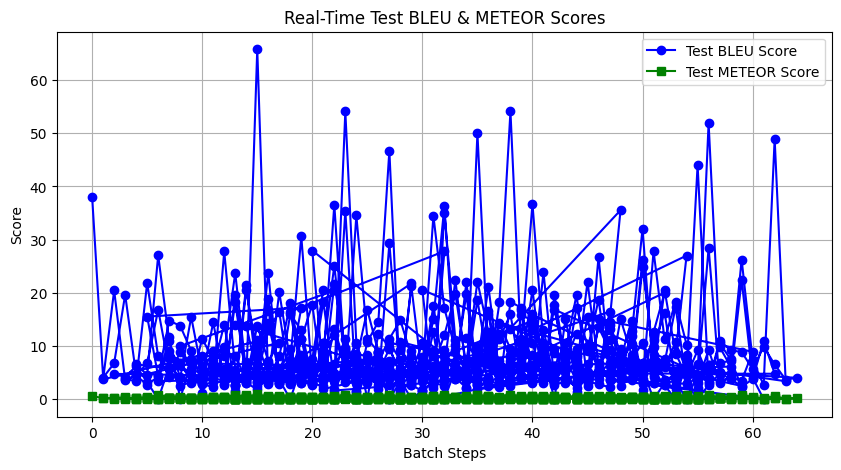

In [41]:
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# ✅ Initialize test evaluation metrics
test_bleu_scores = []
test_meteor_scores = []
test_batch_steps = []

# ✅ Evaluate on test dataset
plt.figure(figsize=(10, 5))  # Real-time plot setup

for batch_idx, batch in enumerate(test_loader):  # Assuming `test_loader` is defined
    if batch is None or len(batch) != 2:  # ✅ Ensure batch has exactly 2 elements
        continue

    images, captions = batch  # ✅ Correct unpacking

    for i in range(len(images)):  # ✅ Process images one by one
        img_tensor = images[i]
        true_caption = captions[i]

        # ✅ Convert true caption (indices → words)
        true_caption_text = " ".join(
            [word for idx in true_caption.tolist() for word, word_idx in vocab.items()
             if word_idx == idx and word not in ["<SOS>", "<EOS>", "<PAD>"]]
        )
        generated_caption = generate_caption(img_tensor, captioning_model, vocab)

        # ✅ Compute BLEU & METEOR scores
        bleu = sacrebleu.sentence_bleu(generated_caption, [true_caption_text]).score
        meteor = meteor_score([true_caption_text.split()], generated_caption.split())

        test_bleu_scores.append(bleu)
        test_meteor_scores.append(meteor)
        test_batch_steps.append(batch_idx + i)  # ✅ Track batch progress

        # ✅ Real-time plot update
        clear_output(wait=True)
        plt.clf()
        plt.plot(test_batch_steps, test_bleu_scores, marker='o', linestyle='-', color='b', label="Test BLEU Score")
        plt.plot(test_batch_steps, test_meteor_scores, marker='s', linestyle='-', color='g', label="Test METEOR Score")
        plt.xlabel("Batch Steps")
        plt.ylabel("Score")
        plt.title("Real-Time Test BLEU & METEOR Scores")
        plt.legend()
        plt.grid()
        display(plt.gcf())

# ✅ Compute final test scores
final_test_bleu = sum(test_bleu_scores) / len(test_bleu_scores)
final_test_meteor = sum(test_meteor_scores) / len(test_meteor_scores)

print(f"\n📊 **Test Evaluation Completed!**")
print(f"✅ **Final Test BLEU Score:** {final_test_bleu:.2f}")
print(f"✅ **Final Test METEOR Score:** {final_test_meteor:.2f}")

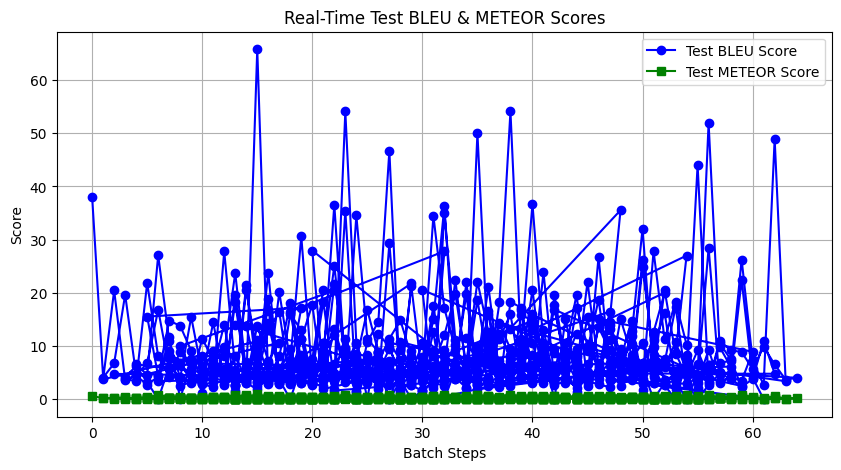


📊 **Test Evaluation Completed!**
✅ **Final Test BLEU Score:** 8.07
✅ **Final Test METEOR Score:** 0.22


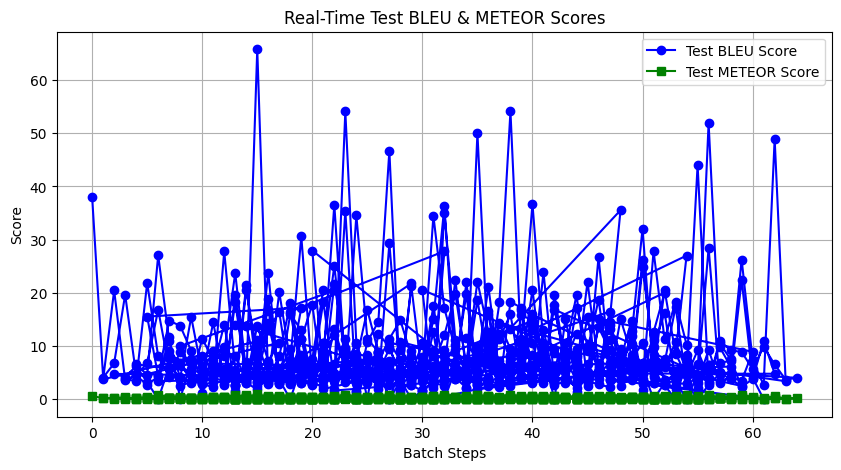

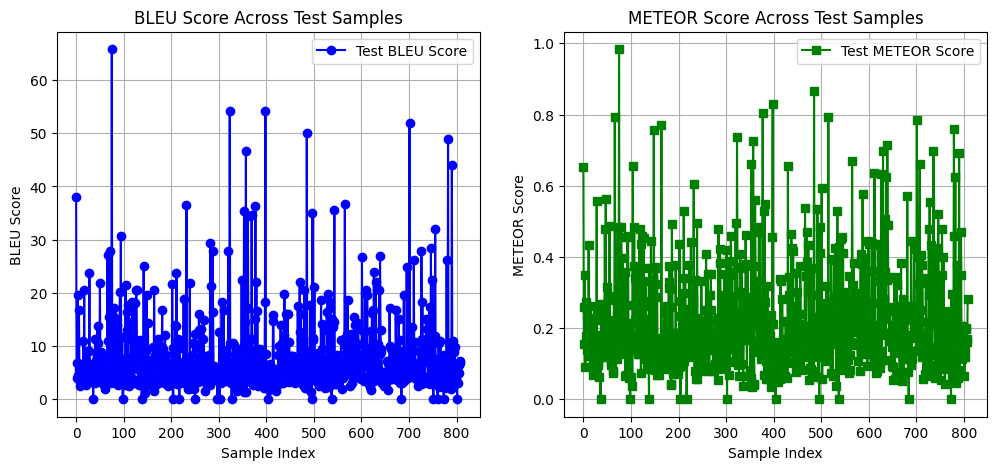

✅ BLEU & METEOR test score graphs plotted successfully!


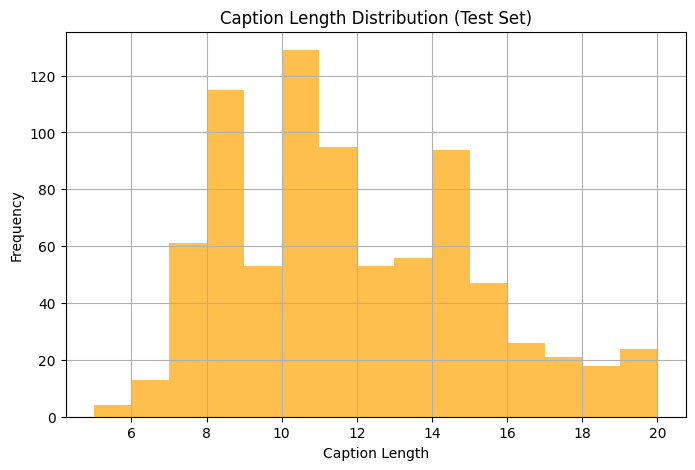

✅ Caption Length Distribution for test set plotted successfully!


<Figure size 1200x1500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


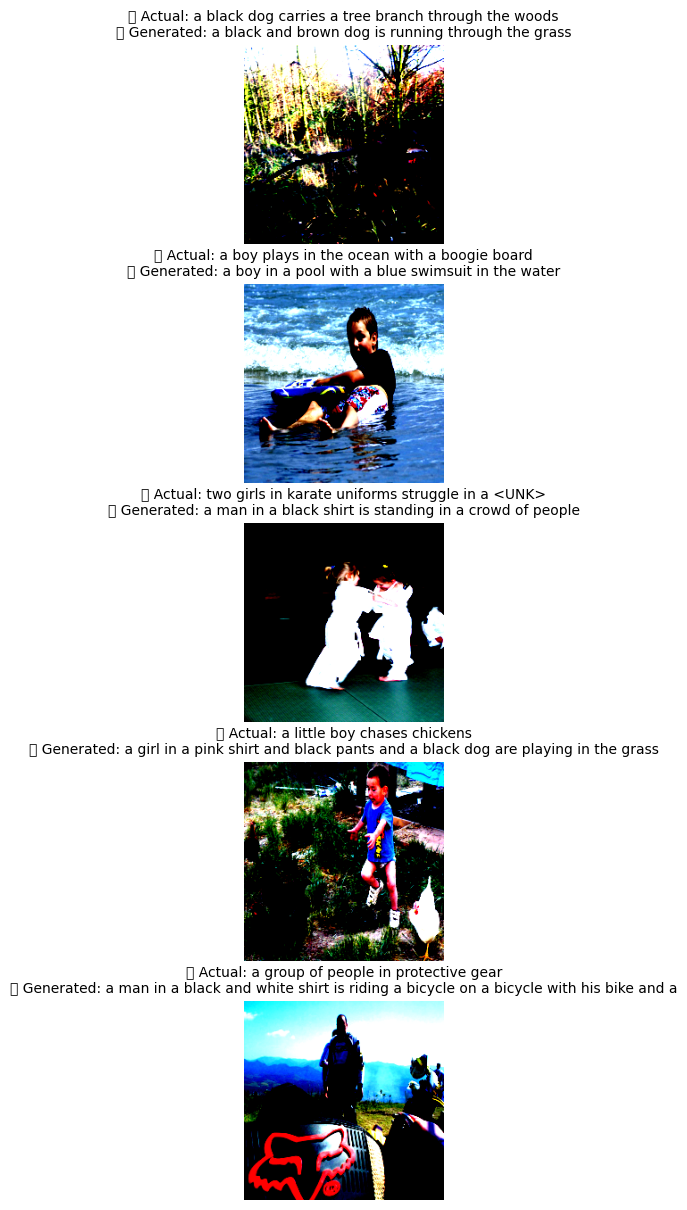

✅ Actual vs. Generated Captions (Test Set) plotted successfully!


In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# ✅ Initialize test evaluation metrics
test_bleu_scores = []
test_meteor_scores = []
test_batch_steps = []
test_caption_lengths = []

# ✅ Evaluate on test dataset
plt.figure(figsize=(10, 5))  # Real-time plot setup

for batch_idx, batch in enumerate(test_loader):  # Assuming `test_loader` is defined
    if batch is None or len(batch) != 2:  # ✅ Ensure batch has exactly 2 elements
        continue

    images, captions = batch  # ✅ Correct unpacking

    for i in range(len(images)):  # ✅ Process images one by one
        img_tensor = images[i]
        true_caption = captions[i]

        # ✅ Convert true caption (indices → words)
        true_caption_text = " ".join(
            [word for idx in true_caption.tolist() for word, word_idx in vocab.items()
             if word_idx == idx and word not in ["<SOS>", "<EOS>", "<PAD>"]]
        )
        generated_caption = generate_caption(img_tensor, captioning_model, vocab)

        # ✅ Compute BLEU & METEOR scores
        bleu = sacrebleu.sentence_bleu(generated_caption, [true_caption_text]).score
        meteor = meteor_score([true_caption_text.split()], generated_caption.split())

        test_bleu_scores.append(bleu)
        test_meteor_scores.append(meteor)
        test_batch_steps.append(batch_idx + i)  # ✅ Track batch progress
        test_caption_lengths.append(len(generated_caption.split()))  # ✅ Track caption lengths

        # ✅ Real-time plot update
        clear_output(wait=True)
        plt.clf()
        plt.plot(test_batch_steps, test_bleu_scores, marker='o', linestyle='-', color='b', label="Test BLEU Score")
        plt.plot(test_batch_steps, test_meteor_scores, marker='s', linestyle='-', color='g', label="Test METEOR Score")
        plt.xlabel("Batch Steps")
        plt.ylabel("Score")
        plt.title("Real-Time Test BLEU & METEOR Scores")
        plt.legend()
        plt.grid()
        display(plt.gcf())

# ✅ Compute final test scores
final_test_bleu = sum(test_bleu_scores) / len(test_bleu_scores)
final_test_meteor = sum(test_meteor_scores) / len(test_meteor_scores)

print(f"\n📊 **Test Evaluation Completed!**")
print(f"✅ **Final Test BLEU Score:** {final_test_bleu:.2f}")
print(f"✅ **Final Test METEOR Score:** {final_test_meteor:.2f}")

# ✅ Plot BLEU & METEOR Scores Across Test Samples
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(test_bleu_scores)), test_bleu_scores, marker='o', linestyle='-', color='b', label="Test BLEU Score")
plt.xlabel("Sample Index")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Across Test Samples")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(len(test_meteor_scores)), test_meteor_scores, marker='s', linestyle='-', color='g', label="Test METEOR Score")
plt.xlabel("Sample Index")
plt.ylabel("METEOR Score")
plt.title("METEOR Score Across Test Samples")
plt.legend()
plt.grid()

plt.show()
print("✅ BLEU & METEOR test score graphs plotted successfully!")

# ✅ Plot Caption Length Distribution (Test Set)
plt.figure(figsize=(8, 5))
plt.hist(test_caption_lengths, bins=np.arange(min(test_caption_lengths), max(test_caption_lengths) + 1, 1), color='orange', alpha=0.7)
plt.xlabel("Caption Length")
plt.ylabel("Frequency")
plt.title("Caption Length Distribution (Test Set)")
plt.grid()
plt.show()

print("✅ Caption Length Distribution for test set plotted successfully!")

# ✅ Visualize Actual vs. Generated Captions (Test Set)
plt.figure(figsize=(12, num_samples * 3))
# ✅ Ensure we don't exceed available samples
num_samples = min(num_samples, len(sample_images), len(true_captions), len(generated_captions))

# ✅ Visualize Actual vs. Generated Captions (Test Set)
plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    plt.subplot(num_samples, 1, i + 1)

    # ✅ Convert tensor to image correctly
    image_data = sample_images[i].permute(1, 2, 0) if sample_images[i].dim() == 3 else sample_images[i]

    plt.imshow(image_data)
    plt.axis("off")
    plt.title(f"🔹 Actual: {true_captions[i]}\n🤖 Generated: {generated_captions[i]}", fontsize=10)

plt.show()
print("✅ Actual vs. Generated Captions (Test Set) plotted successfully!")

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files  # ✅ Import for file uploads in Colab

# ✅ Define Image Transformations (Same as training pipeline)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Function to Load and Process Image
def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transformed_image = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image, transformed_image

# ✅ Multiple Image Upload Loop
while True:
    print("📂 Upload an image for caption generation... (Type 'no' to exit)")
    uploaded = files.upload()  # User uploads an image

    if not uploaded:  # If no file uploaded, ask again
        print("⚠️ No file uploaded. Try again.")
        continue

    image_path = list(uploaded.keys())[0]  # Get uploaded file name

    try:
        # ✅ Process the uploaded image
        image, transformed_image = process_image(image_path)

        # ✅ Generate caption using trained model
        generated_caption = generate_caption(transformed_image.squeeze(0), captioning_model, vocab)

        # ✅ Display Image & Caption
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"🤖 Generated Caption:\n{generated_caption}", fontsize=12)
        plt.show()

        print(f"✅ Generated Caption: {generated_caption}")

    except Exception as e:
        print(f"⚠️ Error: {e}\nMake sure the image is valid and uploaded correctly.")

    # ✅ Ask user if they want to upload another image
    user_input = input("\n🔁 Do you want to upload another image? (yes/no): ").strip().lower()
    if user_input == 'no':
        print("👋 Exiting Image Captioning. Thank you!")
        break  # Stop the loop

📂 Upload an image for caption generation... (Type 'no' to exit)
